# Direction Change on Markov Chains

This evaluation is motivated by the work [Multi-scale Representation of High Frequency Market
Liquidity](https://arxiv.org/pdf/1402.2198.pdf) which models the price changes over a threshold as events/states in a Markov Chain. The paper however also considers hierarchical price changes, which is not considered in this notebook.

The notebook generates directional change data, a Markov Chain and plots some stuff. The sequences are also exported as a HiPlot (html) file.

Finally, the conclusion and outlook indicate further movement directions wrt. prediction of state transitions and feasible trading strategies.





# Params

In [21]:
num_candles_to_load=0#10000
timeframe="1min"
ema_slow=20
ema_fast=5
eps_up=0.05 #minimal change bin price for a change segment for up movement
eps_down=0.05 #minimal change bin price for a change segment for down movement


In [14]:
import numpy as np
import sys
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import helpers
import pandas_ta as ta



In [4]:
#load data
candles_in=helpers.load(num_candles_to_load, summary=timeframe, path_prefix="./")
print("loaded "+str(candles_in.shape[0])+" candles")
#candles_in=candles.iloc[:1000]
candles_in.head()

Loading from ./
Loading ./data/forex/2019/DAT_ASCII_EURUSD_M1_2019.csv
372209 candles loaded!
loaded 372209 candles


open      max      min    close                time  vol       hl2  \
0  1.14598  1.14599  1.14598  1.14598 2019-01-01 23:03:00    0  1.145985   
1  1.14598  1.14607  1.14598  1.14607 2019-01-01 23:04:00    0  1.146025   
2  1.14607  1.14607  1.14606  1.14606 2019-01-01 23:05:00    0  1.146065   
3  1.14606  1.14621  1.14606  1.14621 2019-01-01 23:06:00    0  1.146135   
4  1.14619  1.14666  1.14604  1.14665 2019-01-01 23:07:00    0  1.146350   

   0monthcode  hour  
0           1    23  
1           1    23  
2           1    23  
3           1    23  
4           1    23

# Compute Renko and DC Events

Here we compute the so called `Renko` prices. Basically the `Directional Change`, where at least $\epsilon_{up}$  %  or $\epsilon_{down}$ % are between two price points in time.
![img](https://upload.wikimedia.org/wikipedia/commons/0/09/Directional-change_dissection_procedure.png)

The Directional Change (DC) and the Overshoot (OS) events are marked instantly in the same DataFrame.



In [5]:
def renko_segment(df, colname="close", eps_up=0.1, eps_down=0.1):
    """
    segments the price movements into delta chunks of size threshold.
    means, a new sample is started only if the price moves `threshold` away from the anchor price.
    threshold: in %. e.g. 0.1
    """
    df2=df.copy()
    prices=[]
    dtimes=[]
    last_anchor=df.iloc[0][colname]
    last_ki=0
    events=[]
    last_event=None
    for ki, vi in df.iterrows():
        ri=vi[colname]
        #print(ki)
        #print("ri: "+str(ri))
        #print("ki: "+str(ki))
        plong=(ri/last_anchor-1)*100
        pshort=(1-ri/last_anchor)*100
        #print("last: "+str(last_anchor)+", ri: "+str(ri))
        #print("pshort: "+str(pshort))
        #print("plong: "+str(plong))
        dt=ki-last_ki
        
        if dt>1000:
            dt=0
        if plong >eps_up:
            
            #label the DC event
            #print("long, last_event: "+str(last_event))
            
            if last_event!=None and last_event=="dcup" or last_event=="osu":
                events.append("osu")
            else:
                events.append("dcup")
            last_event=events[-1]
            #print("new event after long: "+str(events[-1]))
            
            prices.append(ri)
            dtimes.append(dt)
            last_anchor=ri
            last_ki=ki
            
        elif pshort > eps_down:
            #print("short, last_event: "+str(last_event))
            #label the DC event
            if last_event!=None and last_event=="dcdown" or last_event=="osd":
                events.append("osd")
            else:
                #print("down?: p[-2]: "+str(prices[-2])+", "+"p[-1]: "+str(prices[-1]))
                events.append("dcdown")
            last_event=events[-1]
            #print("new event after short: "+str(events[-1]))
            prices.append(ri)
            dtimes.append(dt)
            last_anchor=ri
            last_ki=ki
        else:
            #print("skip")
            prices.append(np.nan)
            dtimes.append(np.nan)
            events.append(np.nan)
        
    df2["renko_price"]=prices
    df2["event"]=events
    df2["renko_dt"]=dtimes
    return df2



In [6]:
df2=renko_segment(candles_in, eps_up=eps_up, eps_down=eps_down)
df2.head(100)

#candles["close"]=df2["renko_price"]
df2=df2.dropna()

df2.head(33)
candles=df2 #overwrite the candles by the renko df (the scripts below all rely on the `candles` variable)

Lets have alook on the result. It contains now the prices at the time points when the $\epsilon$ threshold is hit,
the event name in the `event` column and the time difference between the events in the `renko_dt` column:

In [7]:
candles.head(30)

open      max      min    close                time  vol       hl2  \
4    1.14619  1.14666  1.14604  1.14665 2019-01-01 23:07:00    0  1.146350   
5    1.14665  1.14672  1.14607  1.14607 2019-01-01 23:08:00    0  1.146395   
77   1.14658  1.14667  1.14656  1.14667 2019-01-02 00:20:00    0  1.146615   
118  1.14612  1.14612  1.14606  1.14606 2019-01-02 01:01:00    0  1.146090   
154  1.14555  1.14560  1.14543  1.14544 2019-01-02 01:37:00    0  1.145515   
227  1.14494  1.14496  1.14475  1.14486 2019-01-02 02:50:00    0  1.144855   
390  1.14433  1.14435  1.14427  1.14427 2019-01-02 05:33:00    0  1.144310   
435  1.14477  1.14495  1.14475  1.14490 2019-01-02 06:18:00    0  1.144850   
442  1.14543  1.14571  1.14540  1.14568 2019-01-02 06:25:00    0  1.145555   
453  1.14616  1.14630  1.14613  1.14627 2019-01-02 06:36:00    0  1.146215   
459  1.14668  1.14693  1.14668  1.14689 2019-01-02 06:42:00    0  1.146805   
475  1.14693  1.14749  1.14693  1.14749 2019-01-02 06:58:00    0  1.147210   
479  1.14804  1.14834  1.14803  1.14821 2019-01-02 07:02:00    0  1.148185   
488  1.14865  1.14967  1.14864  1.14940 2019-01-02 07:11:00    0  1.149155   
521  1.14885  1.14886  1.14876  1.14880 2019-01-02 07:44:00    0  1.148810   
568  1.14832  1.14834  1.14798  1.14800 2019-01-02 08:31:00    0  1.148160   
593  1.14775  1.14777  1.14737  1.14739 2019-01-02 08:56:00    0  1.147570   
601  1.14703  1.14704  1.14671  1.14681 2019-01-02 09:04:00    0  1.146875   
608  1.14637  1.14637  1.14604  1.14623 2019-01-02 09:11:00    0  1.146205   
614  1.14607  1.14608  1.14548  1.14552 2019-01-02 09:17:00    0  1.145780   
628  1.14532  1.14532  1.14358  1.14405 2019-01-02 09:31:00    0  1.144450   
632  1.14352  1.14356  1.14298  1.14318 2019-01-02 09:35:00    0  1.143270   
635  1.14355  1.14380  1.14340  1.14380 2019-01-02 09:38:00    0  1.143600   
653  1.14437  1.14466  1.14434  1.14458 2019-01-02 09:56:00    0  1.144500   
663  1.14401  1.14417  1.14389  1.14393 2019-01-02 10:06:00    0  1.144030   
677  1.14442  1.14463  1.14432  1.14457 2019-01-02 10:20:00    0  1.144475   
680  1.14428  1.14437  1.14390  1.14390 2019-01-02 10:23:00    0  1.144135   
697  1.14338  1.14338  1.14261  1.14324 2019-01-02 10:40:00    0  1.142995   
699  1.14274  1.14280  1.14221  1.14254 2019-01-02 10:42:00    0  1.142505   
715  1.14283  1.14315  1.14277  1.14314 2019-01-02 10:58:00    0  1.142960   

     0monthcode  hour  renko_price   event  renko_dt  
4             1    23      1.14665    dcup       4.0  
5             1    23      1.14607  dcdown       1.0  
77            1     0      1.14667    dcup      72.0  
118           1     1      1.14606  dcdown      41.0  
154           1     1      1.14544     osd      36.0  
227           1     2      1.14486     osd      73.0  
390           1     5      1.14427     osd     163.0  
435           1     6      1.14490    dcup      45.0  
442           1     6      1.14568     osu       7.0  
453           1     6      1.14627     osu      11.0  
459           1     6      1.14689     osu       6.0  
475           1     6      1.14749     osu      16.0  
479           1     7      1.14821     osu       4.0  
488           1     7      1.14940     osu       9.0  
521           1     7      1.14880  dcdown      33.0  
568           1     8      1.14800     osd      47.0  
593           1     8      1.14739     osd      25.0  
601           1     9      1.14681     osd       8.0  
608           1     9      1.14623     osd       7.0  
614           1     9      1.14552     osd       6.0  
628           1     9      1.14405     osd      14.0  
632           1     9      1.14318     osd       4.0  
635           1     9      1.14380    dcup       3.0  
653           1     9      1.14458     osu      18.0  
663           1    10      1.14393  dcdown      10.0  
677           1    10      1.14457    dcup      14.0  
680           1    10      1.14390  dcdown       3.0  
697           1    10      1.14324     osd      1

Lets compute simple EMACD indicator **on the resulting renko events**.

In [22]:
candles["ema_slow"]=candles.ta.ema(length=ema_slow)
candles["ema_fast"]=candles.ta.ema(length=ema_fast)
candles["emacd"]=candles["ema_fast"]-candles["ema_slow"]


Now we plot the first `nfirst` of the computed renko prices for a better visual feeling.

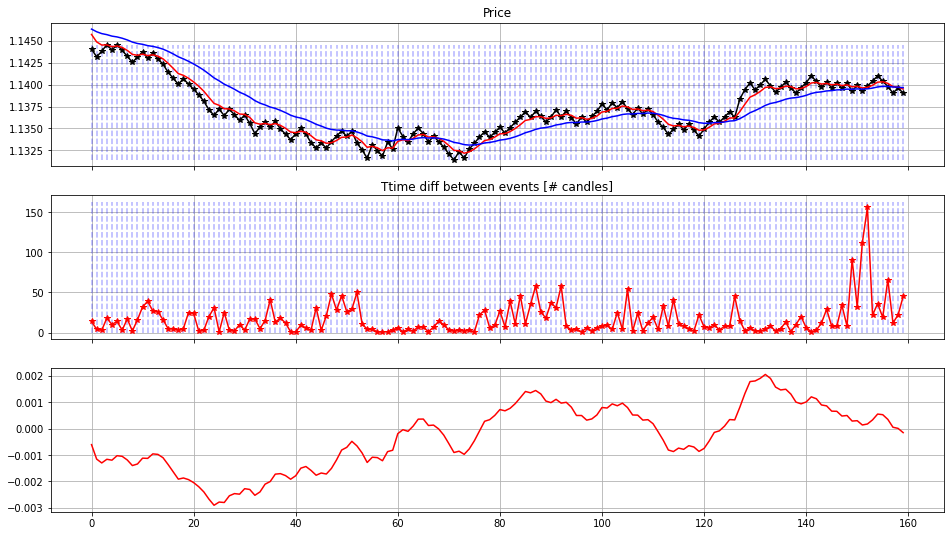

In [25]:
n0=ema_slow
nfirst=n0+160
f, [ax1, ax2, ax3] = plt.subplots(3, sharex=True, sharey=False, figsize=(16, 9))
ax1.plot(df2.iloc[n0:nfirst]["renko_price"].values, label="Close", color="k", marker="*")
ax1.grid()
ax1.set_title("Price")
ax1.vlines(list(range(df2.iloc[n0:nfirst]["renko_price"].values.shape[0])), 
           np.min(df2.iloc[n0:nfirst]["renko_price"].values),  #ymin
           np.max(df2.iloc[n0:nfirst]["renko_price"].values),  #ymax
           colors='blue', linestyles='dashed', alpha=0.3)

ax2.plot(df2.iloc[n0:nfirst]["renko_dt"].values, color="red", label="renko_dt", marker="*")
ax2.grid()
ax2.vlines(list(range(df2.iloc[n0:nfirst]["renko_price"].values.shape[0])), 0, df2.iloc[:nfirst]["renko_dt"].max(), 
           colors='blue', linestyles='dashed', alpha=0.3)
ax2.set_title("Ttime diff between events [# candles]")

#add also the EMA lines
ax1.plot(candles.iloc[n0:nfirst]["ema_fast"].values, label="EMA_fast", color="red")
ax1.plot(candles.iloc[n0:nfirst]["ema_slow"].values, label="EMA_slow", color="blue")


ax3.plot(candles.iloc[n0:nfirst]["emacd"].values, color="red", label="EMACD")
ax3.grid()



# Render With HiPlot

HiPlot is an awesome Tool presenting the data with parallel coordinates in a html page.
Using this, we can quickly get a feeling of the statistical properties of the data.

Hiplot shows each item, which contains several properties (key-value paris). The Hiplot will create N parallel coordinates if the data has N keys.
In order to visualize this, the data needs to be restructured.

Lets try to look at the dependency of the following variables:
* previous state (dc, or os) and the next following state (dc or os). We can however take several previous observations into the sate: state[0], state[1], ... state[k], where state[0] is the recent one.  We define the parameter `k` as a configuration parameter.

* hour of day





In [9]:
# params for state definition
k_lookback_horizon=1 # num of steps to look back


In [26]:
all_samples=[]
for ki, row in candles.iterrows():
    #print(row['renko_price'])
    kii=candles.index.get_loc(ki)
    kii_prev=kii-1
    profit=0
    if kii>0:
        prev_row=candles.iloc[kii_prev]
        profit=(row['renko_price']/prev_row['renko_price']-1)*100
    #print("kii: "+str(kii))
    sample={'next_event':row['event'], 'profit':profit}
    for hki in range(k_lookback_horizon):        
        krow=candles.iloc[kii-hki-1]
        #print(krow)
        sample_i={str(hki)+'evt':krow['event']}
        sample.update(sample_i)
    #print(sample)
    sample['hour']=row['time'].hour
    sample['emacd']=row['emacd']
    all_samples.append(sample)
    #if len(all_samples)>4:
    #    break

all_samples[:2]
    
    

[{'next_event': 'dcup', 'profit': 0, '0evt': 'osd', 'hour': 23, 'emacd': nan},
 {'next_event': 'dcdown',
  'profit': -0.0505821305542109,
  '0evt': 'dcup',
  'hour': 23,
  'emacd': nan}]

# Export to a HTML file

In [27]:
helpers.hiplot_samples(samples=all_samples, target_name="profit", hiplot_out="/tmp/directional_change_sequences.html")


Written the HiPlot to /tmp/directional_change_sequences.html


# Build and analyze Markov Chain

all states: ['0dcup|1osd|', '0osu|1osu|', '0osd|1dcdown|', '0dcup|1dcdown|', '0osd|1osd|', '0osu|1dcup|', '0dcdown|1osu|', '0dcdown|1dcup|']


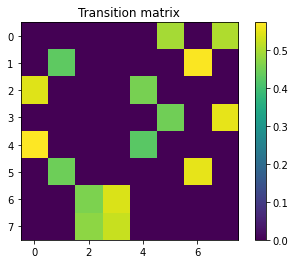

In [12]:
#collect possible states first
def map_state_id(state_row):
    #print(state_row)
    #build full state id as string
    state_id=""
    for ks, vs in state_row.items():
        if "evt" in ks: #we expect to find "evt" in the key representing the event(=state)
            state_id+=ks[0]+vs+"|"
    #print("state id: "+str(state_id))
    return state_id
    
all_states=[map_state_id(si) for si in all_samples]
#make the all_states unique
all_states=list(set(all_states))

print("all states: "+str(all_states))


#print(all_states)
nstates=len(all_states)
P=np.zeros((nstates,nstates))
#print(P)
#now iterate over the time series
for i in range(1, len(all_samples)):
    s0=all_samples[i-1]
    s1=all_samples[i]
    
    #print("transition from s0: "+str(s0)+" to s1: "+str(s1))
    #build full state id as string
    state_id_t0=map_state_id(s0)
    state_id_t1=map_state_id(s1)
    
            
    #print("state_id_t0: "+str(state_id_t0))
    #print("state_id_t1: "+str(state_id_t1))

    
    #print(all_states[0])
    #print("k0: "+k0)
    #print("k1: "+str(k1))
    i0=all_states.index(state_id_t0)
    i1=all_states.index(state_id_t1)
    #print("i0: "+str(i0)+", i1: "+str(i1))
    P[i0, i1]+=1
    
#normalize to probability values
row_sums = P.sum(axis=1)
Pproba = P/ row_sums[:, np.newaxis]

plt.imshow(Pproba)
plt.colorbar()
plt.title("Transition matrix")
plt.show()

In [13]:
P

array([[  0.,   0.,   0.,   0.,   0., 465.,   0., 475.],
       [  0., 319.,   0.,   0.,   0.,   0., 423.,   0.],
       [512.,   0.,   0.,   0., 427.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 480.,   0., 589.],
       [428.,   0.,   0.,   0., 319.,   0.,   0.,   0.],
       [  0., 423.,   0.,   0.,   0.,   0., 522.,   0.],
       [  0.,   0., 435., 510.,   0.,   0.,   0.,   0.],
       [  0.,   0., 505., 559.,   0.,   0.,   0.,   0.]])

## Compute the stationary statistics
following this introduction: https://stephens999.github.io/fiveMinuteStats/stationary_distribution.html

The lower the entropy, the better.


In [14]:
b=np.zeros(nstates)
b[-1]=1
A=Pproba-np.eye(nstates)
pi=np.dot(np.linalg.pinv(A), b)
print(pi)

[-0.0989236   0.33474992  0.13613185 -0.13448695  0.10084294  0.36942838
  0.13506449 -0.84280702]


## Compute the entropy of the MC transition matrix
The better the predictability of the price actions, the **lower** is the entropy.
Thus, we are looking for parameters with minimal Entropy!



In [15]:
hent=0.0
for i in range(nstates):
    for j in range(nstates):
        mui=pi[i]
        pij=Pproba[i,j]
        if pij!=0:
            #print("pij: "+str(pij))
            hi=mui*pij*np.log(pij)
            #print("hi: "+str(hi))
            #print("np.log(pij): "+str(np.log(pij)))
            hent-=hi
print("Entropy: "+str(hent))

Entropy: -0.005599867696714611


Entropy below 0.1 is a good thing. Meaning, that there is not much randomness.

From here on we will not use the Marko Chain Matrix (yet, in this script). However, it can be used to classify the market regime: we can collect M DC events from live data and compute the probability of this sequence using the P matrix from this notebook. If the probability is super low, than the market does not behave as we have modelled here and it might be a good idea to stop trading with real money.





# Trading Strategy

We employ here a very simple strategy, which can be simulated just by iterating over the candles.

From the parameters, we can set one of the two options:

* Trend following: every time the iteration hits a DCup, we go long. When DCdown is hit, we go short.
* Counter trend: every time we hit a DCup, we go short and vice versa


In [16]:
# Strategy params
leverage=500
martingale_on=True
martingale_factor=1.6
account_init_size=1 #initial account size
default_entry_qty=0.01 # in Lots. 1% of the account is the default entry
prev_positions=[] #storage of previous positions
spread=6e-5

#For trend following positions use these two lines
#dc_pos_up="long"
#dc_pos_down="short"

#For counter trend position use these two lines
dc_pos_up="short"
dc_pos_down="long"


def compute_qty(prev_positions):
    """
    computes the entry quantity using the previous position history.
    """
    if len(prev_positions)>0 and prev_positions[-1]['gain']<0:
        return  martingale_factor*prev_positions[-1]['qty']
    else:
        return default_entry_qty

In [17]:
position=None
prev_positions=[]
account_size=account_init_size

for idx, row in candles.iterrows():
    #print(row)
    if row['event']=="dcup":
        #print("dcup")
        #if there is a short position opened, close it and compute the gain
        if position!=None:
            if position['type']==dc_pos_down:
                #print("was short: "+str(position))
                p0=row['renko_price']+spread
                if dc_pos_up=="long":
                    pnl=p0/position['entry_price']-1
                else:
                    pnl=position['entry_price']/p0-1
                gain={'gain': pnl*position['qty']*leverage , 'pnl':pnl*leverage}
                #print("gain: "+str(gain)+", p0: "+str(p0)+", pnl: "+str(pnl))
                position.update(gain)
                prev_positions.append(position)
                qty=compute_qty(prev_positions)
                #open a new LONG position
                position={'type':dc_pos_up, 'qty': qty, 'entry_price':row['renko_price']+spread} 
        else:
            qty=compute_qty(prev_positions)
            #open a new LONG position
            position={'type':dc_pos_up, 'qty': qty, 'entry_price':row['renko_price']+spread} 
                
    elif row['event']=="dcdown":
        #print("dcdown")
        #if there is a long position opened, close it and compute the gain
        if position!=None:
            if position['type']==dc_pos_up:
                #print("was long: "+str(position))
                p0=row['renko_price'] #no spread here. the candle data are BID prices
                if dc_pos_down=="short":
                    pnl=p0/position['entry_price']-1
                else:
                    pnl=position['entry_price']/p0-1
                    
                gain={'gain': pnl*position['qty']*leverage, 'pnl':pnl*leverage}
                #print("gain: "+str(gain)+", p0: "+str(p0)+", pnl: "+str(pnl))
                position.update(gain)
                prev_positions.append(position)
                qty=compute_qty(prev_positions)
                #open a new SHORT position
                position={'type':dc_pos_down, 'qty': qty, 'entry_price':row['renko_price']} #minus the spread 0f 0.6 pips
        else:
            qty=compute_qty(prev_positions)
            #open a new SHORT position
            position={'type':dc_pos_down, 'qty': qty, 'entry_price':row['renko_price']}
            
    

#now compute the final account value
acc_vals=[account_size]
gains=[pi['gain'] for pi in prev_positions]
for pi in prev_positions:
    #print("gain: "+str(pi['gain']))
    account_size+=pi['gain'] #pi['qty']*(pi['pnl']+1)
    acc_vals.append(account_size)
print("Final Account value: "+str(account_size)+ "LOTs")
print("Final gain: "+str((account_size/account_init_size-1)*100)+" % with leverage: "+str(leverage)+"x")
sharpe=np.mean(gains)/np.std(gains)
print("Sharpe Ratio: "+str(sharpe))

Final Account value: 2.3205568323332426LOTs
Final gain: 132.05568323332426 % with leverage: 500x
Sharpe Ratio: 0.029198590859531297


Now lets examine the results:

Num positinos: 4017


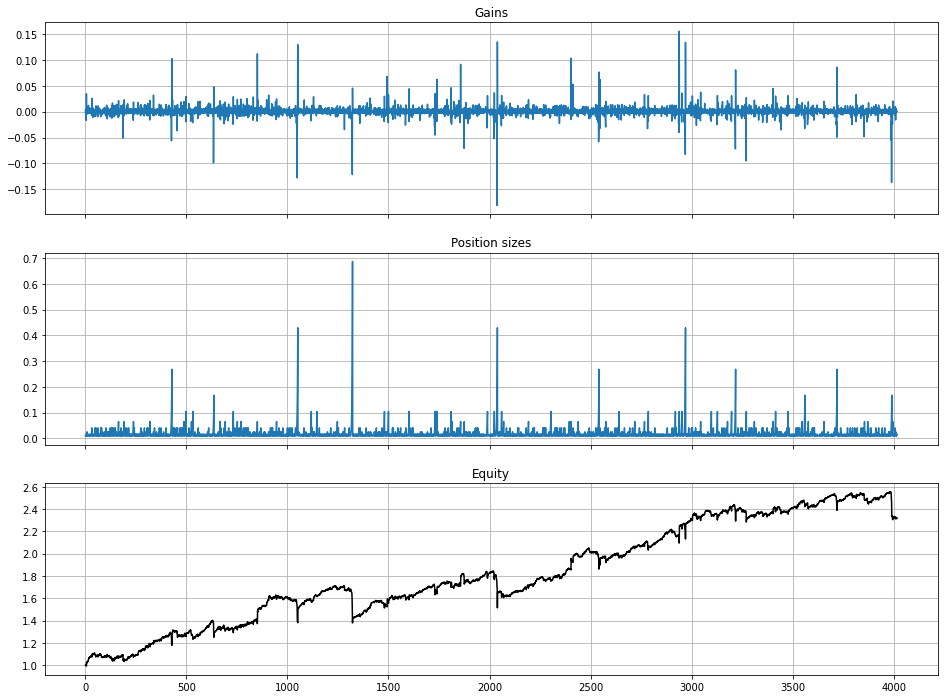

In [18]:
# Amount of positions:
print("Num positinos: "+str(len(prev_positions)))
f, [ax1, ax2, ax3] = plt.subplots(3, sharex=True, sharey=False, figsize=(16, 12))

#ax1.bar(list(range(len(prev_positions))), [pi['gain'] for pi in prev_positions], label="Gains")
gains=[pi['gain'] for pi in prev_positions]
#print(gains)
ax1.plot(gains, label="Gains")
ax1.set_title("Gains")

ax1.grid()

qtys=[pi['qty']for pi in prev_positions]
ax2.plot(qtys)
ax2.set_title("Position sizes")
ax2.grid()

ax3.plot(acc_vals, color="k")
ax3.set_title("Equity")
ax3.grid()


Now lets have a look on the risk involved: for now, we look at the histogram of all negative gains

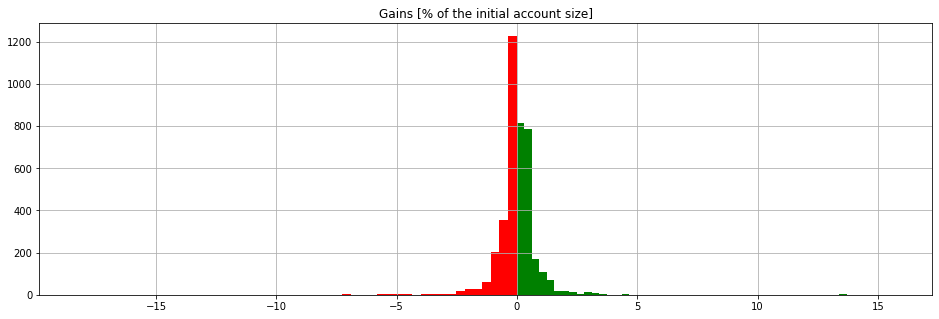

In [19]:
gains=np.array(gains)
pos_gains=gains[gains>0]
losses=gains[gains<0]#np.argwhere(np.array(gains) <0)

f, ax1 = plt.subplots(1, sharex=True, sharey=False, figsize=(16, 5))

ax1.hist(losses*100, color="red", bins=50)
ax1.hist(pos_gains*100, color="green", bins=50)
ax1.set_title("Gains [% of the initial account size]")
ax1.grid()

# Conclusion 
The direction change framework simplifies the price movement formulation. The simulated simple trading strategies are shown to be profitable (the counter trendy one). Using $\epsilon=0.05$ the equity of the strategy reaches $\approx$ 22%. This can be simply improved if we take the involved risk into account and exit at a reasonable Stop-Loss (e.g. -1% of the account value).

From the HiPlot visualization (see file `/tmp/directional_change_sequences.html`) this strategy would lead to exactly 50% up-overshoots and 50% directional changes in the other direction (`dcdown`). This is also visible in the transition Matrix $P$ shown above.
This shows that the DC topic has been deeply integrated into the trading strategies of many market players.




# Outlook

**Predicting Transitions:**

* Even if the current transition matrix does not give much information for an **Alpha**, there might be some ways to predict the transition using technical indicators or some specific features.

* There is a quite new Book from that guy, which uses for example the time between the previous events to predict the DC. https://www.bracil.net/finance/DirectionalChanges/

* One should also try to combine EMACD, Bollinger and Keltner lines (e.g. price - upper_keltner_level) as features to predict the next transistion using XGBoost

* Using the histogram of log-returns between last DC-triggers might help to predict the transitions via a simple KNN-search (e.g. using the sklearn-library)

* Using Matrix-Profile search instead of knn for histograms to match similar patterns in history and to predict the transition.

* Using technical analysis (TA) indicators, histograms and Matrix-Profile all together using XGBoost


**Trading Strategies:**

Sofar no trading strategy has been analyzed here. In the Paper [The Alpha Engine: Designing an Automated Trading Algorithm](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2951348) from Anton Golub et al, they achieve a sharpe ratio of 3 using a ["coastline strategy"](https://www.fxstreet.com/trading). This basically opens between the DC events with a fixed (small) take-profit offsets but without stop-losses. 

Since money management should be an integral part of a strategy, one could start using a very basic one (go long if `dcup`) and focusing on the money management strategy which will make the overall activities profitable. See the introductory book [The Leverage Space Trading Model: Reconciling Portfolio Management](https://b-ok.cc/book/720419/015ca1) or [The Mathematics of Money Management: Risk Analysis Techniques for Traders](https://b-ok.cc/book/527155/dff76d) which is more advanced.

Some people work for a while with "directional changes" but call them Renko-Charts. This blog for example proposes a combination of TA indicators and heuristics for finding good entries and exits. This definetly is also a good perspective worth trying. https://protrader.org/blog/trading-with-turbo-renko-chart